# Final Assignment Notebook

The code below belongs to Group C and is for the Final Assignment of CSCK503 Machine Learning in Practice. The scenario for building this ML model can be seen below.

You have been engaged as a contract data scientist by Athana Data Science Services (ADSS), a small company specialising in the provision of data science consultancy services to public and private sector organisations. ADSS have just been awarded a contract by a government department (the Department of Environment) to help with the development of machine learning-based models for predicting atmospheric emissions (and pollution) from data gathered by various borough and county environment monitoring units. Your team leader wants you to assist with this project, and you will be required to carry out a number of tasks using the Anaconda/Scikit-Learn Python ML framework and its components.

## Import Libraries

In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,median_absolute_error, max_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

#dashbaord
import dash
from dash import html, dcc
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import base64
from IPython.display import HTML


## Load in datasets and concatenate dataframes

In [2]:
df_2008_org = pd.read_excel('Major Roads/LAEI2013_MajorRoads_EmissionsbyLink_2008.xlsx')
df_2010_org = pd.read_excel('Major Roads/LAEI2013_MajorRoads_EmissionsbyLink_2010.xlsx')
df_2013_org = pd.read_excel('Major Roads/LAEI2013_MajorRoads_EmissionsbyLink_2013.xlsx')
df_2020_org = pd.read_excel('Major Roads/LAEI2013_MajorRoads_EmissionsbyLink_2020.xlsx')

# Remove unneeded column
df_2020_org = df_2020_org.drop(['DotRef'], axis=1)

# Renaming Borough_ExactCut to the same name so they combine with each other after concatenation
df_2008_org = df_2008_org.rename(columns={'BoroughExactCut': 'Borough_ExactCut'})
df_2013_org = df_2013_org.rename(columns={"BoroughExactCut": "Borough_ExactCut"})
df_2020_org = df_2020_org.rename(columns={"BoroughExactCut": "Borough_ExactCut"})


main_df = pd.concat([df_2008_org, df_2010_org, df_2013_org, df_2020_org])
main_df.info()

#Dashboards Data 
model_metrics = {}

<class 'pandas.core.frame.DataFrame'>
Index: 1574746 entries, 0 to 402841
Data columns (total 33 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   GridId                1574746 non-null  int64  
 1   Toid                  1574746 non-null  int64  
 2   GRID_ExactCut_ID      1574746 non-null  int64  
 3   Location_ExactCut     1574746 non-null  object 
 4   Borough_ExactCut      805684 non-null   object 
 5   Lts                   1574746 non-null  int64  
 6   Length (m)            1574746 non-null  float64
 7   Emissions             1574746 non-null  object 
 8   Year                  1574746 non-null  int64  
 9   Pollutant             1574746 non-null  object 
 10  Emissions Unit        1574746 non-null  object 
 11  Motorcycle            1574746 non-null  float64
 12  Taxi                  1574746 non-null  float64
 13  Car                   1574746 non-null  float64
 14  BusAndCoach           1574746 non-null  

## Function to convert all object columns to Numeric Encoding

In [3]:
def convert_object_columns_to_numeric(df):
    """
        This function takes a dataframe and will first find all object type columns, loop through each of them and encode them using a LabelEncoder object. This will ensure
        that the dataframe will not contain anymore object columns.
    """

    label_encoder = LabelEncoder()
    categorical_columns = df.select_dtypes(include=['object']).columns # Code to find all column names that are object type
    df_encoded = df.copy()

    for col in categorical_columns:
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col]) # Label encode each object type column
        df_encoded[col] = df_encoded[col].astype(int) # And convert the column to integer

    df_encoded.info()
    return df_encoded

## Function to split the data based on target column and filter train/test set based on the Year of the data

In [4]:
def split_data_based_on_target_label(df, target_column, test_year):
    """
        This function is responsible for taking in a dataframe, a target column, and a test year and will split the dataframe into an X and Y dataframe based on the target column.
        Then will take all rows with a Year value of less than the test_year and will use this as the training set and everything equal to or above the test year is part of the test set.
        E.g. if test_year = 2020 then all rows < 2020 will be training and all >= 2020 will be part of the test set.
    """
    train_set = df[df['Year'] < test_year]
    test_set = df[df['Year'] >= test_year]

    X_train = train_set.drop(target_column, axis=1)
    y_train = train_set[target_column]

    X_test = test_set.drop(target_column, axis=1)
    y_test = test_set[target_column]

    return X_train, X_test, y_train, y_test

## Function to analyze the performance of the model

In [69]:
def analyze_model(y_test, predictions, model_type, model, X_train):   # model, X_train params used to generate featur importance chart
    """
        This function is used to compare the predictions of the model and the actual ground truth labels to assess performance
    """
    mse = mean_squared_error(y_test, predictions)
    print("Mean Squared Error (MSE):", mse)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, predictions)
    print("Mean Absolute Error (MAE):", mae)

    # Median Absolute Error
    median_ae = median_absolute_error(y_test, predictions)
    print("Median Absolute Error:", median_ae)

    # Max Error
    max_err = max_error(y_test, predictions)
    print("Max Error:", max_err)
    
    # R-squared (R2) Score
    r2 = r2_score(y_test, predictions)
    print("R-squared (R2) Score:", r2)

    # Plotting actual vs predicted values
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title(model_type + ' Actual vs. Predicted Values')
    # Plotting the identity line; perfect predictions would lie on this line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.savefig(model_type+ '.png', bbox_inches='tight')

    plt.show()

    #feature importance    
    if hasattr(model, 'feature_importances_'):
        # Model has feature importances, so we can retrieve and plot them
        feature_importances = model.feature_importances_
        sorted_indices = np.argsort(feature_importances)[::-1]
        
        #plt.figure(figsize=(10, 6))
        plt.title(f'{model_type} Feature Importances')
        plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
        plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
        plt.ylabel('Importance')
        plt.xlabel('Feature')
        plt.show()

    #add values to metrics dashboard dictionary
    model_metrics[model_type] = {'MSE': mse, 'RMSE': rmse , 'MAE' : mae, 'R2': r2}

    return mse, rmse

## Function to perform model training

In [20]:
def train_and_analyze_model(X_train, y_train, X_test, y_test, model, model_type):
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    # Call analyze function to analyze the performance of the model
    mse, rmse = analyze_model(y_test, predictions, model_type, model,X_train)
    return mse, rmse

## Neural Network Architecture

In [7]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## Function to build the neural network model

In [94]:
def build_neural_network_and_analyze_model(X_train, y_train, X_test, y_test, model_type):
    """
        This function will be used to take the data and scale it, convert to tensors, and train a Neural Network model and generate predictions from it. Then will call the analyze function to analyze performance.
    """
    # Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Reshape y tensors to match the output shape
    y_train_tensor = y_train_tensor.view(-1, 1)
    y_test_tensor = y_test_tensor.view(-1, 1)

    # Initialize the network
    input_size = X_train_tensor.shape[1]
    model = Net(input_size)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    epochs = 8000
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Predict on the test data
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)

    # Compute the loss (MSE) and other metrics (MAE and R²)
    mse = criterion(predictions, y_test_tensor).item()
    mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()  
    r2 = 1 - (torch.sum((y_test_tensor - predictions) ** 2) / torch.sum((y_test_tensor - torch.mean(y_test_tensor)) ** 2)).item()
        
    print(f"Local mse, mae and r2 values are {mse}, {mae}, {r2}")
    mse, rmse = analyze_model(y_test_tensor, predictions, model_type, model, X_train_scaled)
    return mse, rmse


In [96]:
def split_dataset_and_train_models(df, target_column, model_list, test_year=2020):
    df_encoded = convert_object_columns_to_numeric(df)
    X_train, X_test, y_train, y_test = split_data_based_on_target_label(df_encoded, target_column, test_year)
    lowest_mse_algorithm = ""
    lowest_mse = 999999
    lowest_rmse_algorithm = ""
    lowest_rmse = 999999
    for model in model_list:
        if model != "NeuralNetwork":
            mse, rmse = train_and_analyze_model(X_train, y_train, X_test, y_test, model_list[model], model)
        else:
            mse, rmse = build_neural_network_and_analyze_model(X_train, y_train, X_test, y_test, model)
        if mse < lowest_mse:
            lowest_mse = mse
            lowest_mse_algorithm = model
    
        if rmse < lowest_rmse:
            lowest_rmse = rmse
            lowest_rmse_algorithm = model

    print(f"Best performing algorithm according to Mean Squared Error is {lowest_mse_algorithm} and has a value of {lowest_mse}")
    print(f"Best performing algorithm according to Root Mean Squared Error is {lowest_rmse_algorithm} and has a value of {lowest_rmse}")
    ShowDashboard()

## Build Metrics Dashboards

In [138]:
#Create Dashbaords
def create_table_figure(metrics, values, title):

    fig = go.Figure(data=[go.Table(
        header=dict(values=['Metric', 'Value'],
                    line_color='darkslategray',
                    fill_color='lightgrey',
                    align='center',
                    font=dict(color='black', size=12)),
        cells=dict(values=[metrics, values],
                   line_color='darkslategray',
                   fill_color='white',
                   align='center',
                   font=dict(color='darkslategray', size=10)))
    ])
    fig.update_layout(
        title_text=title,
        title_x=0.5,
        margin=dict(l=20, r=20, t=40, b=20),
        
    )
    return fig
    


def ShowDashboard():    
    # Metrics Data
    dt_metrics = ["Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)", "R-squared (R2) Score"]
    dt_values = [ float(model_metrics['DecisionTreeRegressor']['MSE'])
                 , float(model_metrics['DecisionTreeRegressor']['RMSE']), float(model_metrics['DecisionTreeRegressor']['MAE'])
                                                                                  , float(model_metrics['DecisionTreeRegressor']['R2'])]  
    ols_metrics = ["Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)", "R-squared (R2) Score"]
    ols_values = [ float(model_metrics['LinearRegression']['MSE'])
                 , float(model_metrics['LinearRegression']['RMSE']), float(model_metrics['LinearRegression']['MAE'])
                                                                                 , float(model_metrics['LinearRegression']['R2'])]  
    nn_metrics = ["Mean Squared Error (MSE)","Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)", "R-squared (R2) Score"]
    
    nn_values = [ float(model_metrics['NeuralNetwork']['MSE'])
                 , float(model_metrics['NeuralNetwork']['RMSE']), float(model_metrics['NeuralNetwork']['MAE'])
                                                                                   , float(model_metrics['NeuralNetwork']['R2'])]  
    # Initialize Dash app with a nice Bootstrap theme
    app = dash.Dash(__name__, external_stylesheets=[dbc.themes.LUX])
    
    # Custom styling for tables

    #laod images:
    with open("NeuralNetwork.png", "rb") as image_file:
        NeuralNetwork_encoded_string = base64.b64encode(image_file.read()).decode()

    with open("DecisionTreeRegressor.png", "rb") as image_file:
        DecisionTreeRegressor_encoded_string = base64.b64encode(image_file.read()).decode()

    with open("LinearRegression.png", "rb") as image_file:
        LinearRegression_encoded_string = base64.b64encode(image_file.read()).decode()


# Create the HTML string with the base64 encoded image

    # Figures for each model
    dt_fig = create_table_figure(dt_metrics, dt_values, "Decision Tree Regressor Metrics")
    ols_fig = create_table_figure(ols_metrics, ols_values, "Linear Regression OLS Metrics")
    nn_fig = create_table_figure(nn_metrics, nn_values, "Neural Network Metrics")
    
    app.layout = dbc.Container([
        # Section title without extra space
        html.Div("Model Performance Metrics", className="text-center", style={'font-size': '24px', 'font-weight': 'bold'}),
        
        # Row for model metrics figures and plots with no gutters
        dbc.Row([
            dbc.Col([
                dcc.Graph(id='dt-metrics', figure=dt_fig),
                html.Img(src=f'data:image/png;base64,{DecisionTreeRegressor_encoded_string}', style={'width': '100%', 'padding': '10px'})


                #html.Img(src='DecisionTreeRegressor.png', style={'width': '100%', 'padding': '10px'})
            ], lg=4, className="mb-3"),
            dbc.Col([
                dcc.Graph(id='ols-metrics', figure=ols_fig),
                html.Img(src=f'data:image/png;base64,{LinearRegression_encoded_string}', style={'width': '100%', 'padding': '10px'})

            ], lg=4, className="mb-3"),
            dbc.Col([
                dcc.Graph(id='nn-metrics', figure=nn_fig),
                html.Img(src=f'data:image/png;base64,{NeuralNetwork_encoded_string}', style={'width': '100%', 'padding': '10px'})

            ], lg=4, className="mb-3")
        ], className="g-0", align="center")  # No gutters
    ], fluid=True)
    
    if __name__ == '__main__':
        app.run_server(debug=True)

## Model Execution

<class 'pandas.core.frame.DataFrame'>
Index: 1574746 entries, 0 to 402841
Data columns (total 33 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   GridId                1574746 non-null  int64  
 1   Toid                  1574746 non-null  int64  
 2   GRID_ExactCut_ID      1574746 non-null  int64  
 3   Location_ExactCut     1574746 non-null  int32  
 4   Borough_ExactCut      1574746 non-null  int32  
 5   Lts                   1574746 non-null  int64  
 6   Length (m)            1574746 non-null  float64
 7   Emissions             1574746 non-null  int32  
 8   Year                  1574746 non-null  int64  
 9   Pollutant             1574746 non-null  int32  
 10  Emissions Unit        1574746 non-null  int32  
 11  Motorcycle            1574746 non-null  float64
 12  Taxi                  1574746 non-null  float64
 13  Car                   1574746 non-null  float64
 14  BusAndCoach           1574746 non-null  

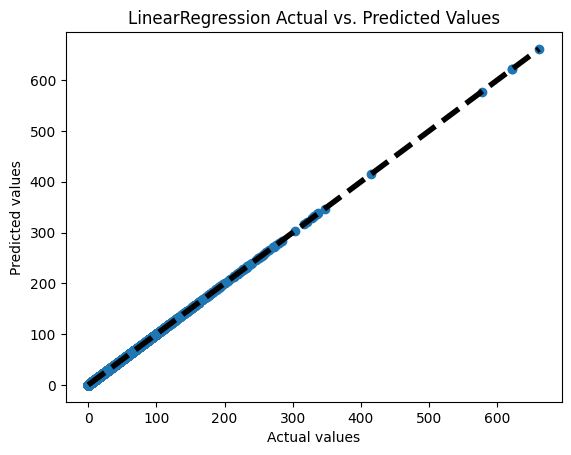

Mean Squared Error (MSE): 3.013003519938402
Root Mean Squared Error (RMSE): 1.7358005415192155
Mean Absolute Error (MAE): 0.20282337273812123
Median Absolute Error: 4.549407937559145e-05
Max Error: 396.82348598286
R-squared (R2) Score: 0.9493071916624728


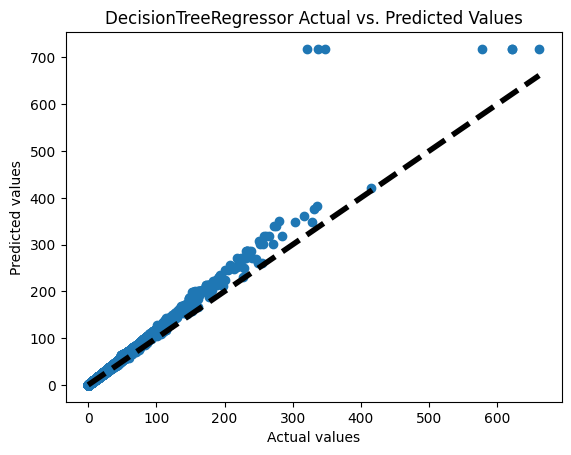

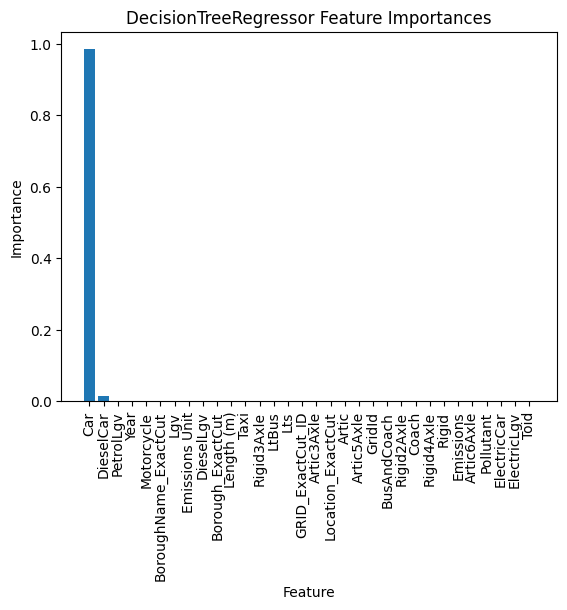

Epoch [10/8000], Loss: 5174626.5000
Epoch [20/8000], Loss: 958712.3125
Epoch [30/8000], Loss: 97810.0312
Epoch [40/8000], Loss: 137484.0469
Epoch [50/8000], Loss: 85160.6875
Epoch [60/8000], Loss: 27943.5234
Epoch [70/8000], Loss: 11443.8740
Epoch [80/8000], Loss: 4224.4111
Epoch [90/8000], Loss: 1081.8597
Epoch [100/8000], Loss: 3228.4038
Epoch [110/8000], Loss: 4137.6255
Epoch [120/8000], Loss: 600.1336
Epoch [130/8000], Loss: 311.3488
Epoch [140/8000], Loss: 264.2802
Epoch [150/8000], Loss: 374.9658
Epoch [160/8000], Loss: 152.9466
Epoch [170/8000], Loss: 153.4904
Epoch [180/8000], Loss: 924.9992
Epoch [190/8000], Loss: 231.6235
Epoch [200/8000], Loss: 355.3332
Epoch [210/8000], Loss: 186.6699
Epoch [220/8000], Loss: 649.6814
Epoch [230/8000], Loss: 327.1553
Epoch [240/8000], Loss: 183.3013
Epoch [250/8000], Loss: 134.8718
Epoch [260/8000], Loss: 117.8628
Epoch [270/8000], Loss: 110.6076
Epoch [280/8000], Loss: 48277.5977
Epoch [290/8000], Loss: 20838.6465
Epoch [300/8000], Loss: 87

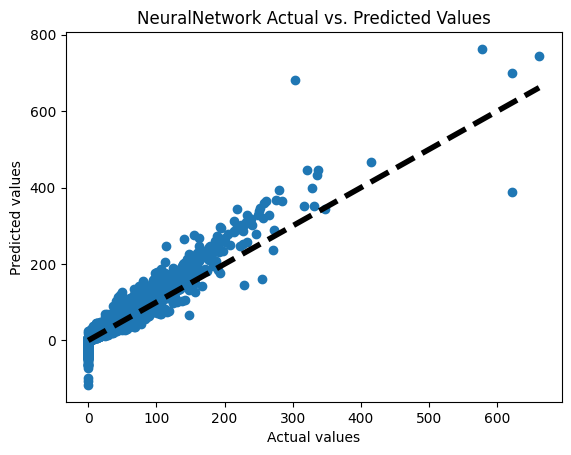

Best performing algorithm according to Mean Squared Error is LinearRegression and has a value of 2.6744439968820793e-21
Best performing algorithm according to Root Mean Squared Error is LinearRegression and has a value of 5.171502679958775e-11


In [97]:
model_list = {"LinearRegression": LinearRegression(), "DecisionTreeRegressor": DecisionTreeRegressor() , "NeuralNetwork": True}


split_dataset_and_train_models(main_df, "PetrolCar", model_list, 2020)
ShowDashboard()